#autoencoder

In [0]:
import keras
from keras.layers import BatchNormalization, Activation, Input
from keras.layers import Reshape, UpSampling2D, Conv2D
from keras.models import Model
from keras.datasets import cifar10
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
#from keras.initializers import he_normal

def build_encoder(x):
    input_ = Input(x.shape[1:])

    c = Conv2D(32, (3, 3), padding="same", strides=2)(input_)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = Conv2D(64, (3, 3), padding="same", strides=2)(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = Conv2D(128, (3, 3), padding="same", strides=2)(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = Conv2D(256, (3, 3), padding="same", strides=2)(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = Conv2D(512, (3, 3), padding="same", strides=2)(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)

    return Model(inputs=input_, outputs=c)

def build_decoder(x):
    input_ = Input([int(x.shape[1]/16), int(x.shape[2]/16), 512])

    c = Conv2D(512, (3, 3), padding="same")(input_)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = UpSampling2D((2,2))(c)#4*4
    c = Conv2D(256, (3, 3), padding="same")(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = UpSampling2D((2,2))(c)#8*8
    c = Conv2D(128, (3, 3), padding="same")(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = UpSampling2D((2,2))(c)#16*16
    c = Conv2D(64, (3, 3), padding="same")(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = UpSampling2D((2,2))(c)#32*32
    c = Conv2D(32, (3, 3), padding="same")(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = UpSampling2D((2,2))(c)#32*32

    c = Conv2D(3, (1, 1), padding="same")(c)
    c = BatchNormalization()(c)
    c = Activation("sigmoid")(c)

    return Model(inputs=input_, outputs=c)

def cifar():
    # dataset
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    return x_train, x_test, y_train, y_test

def train_autoencoder(x, epoch=50):
    encoder = build_encoder(x)
    decoder = build_decoder(x)
    input_ = Input(x.shape[1:])
    ae = Model(inputs = input_, outputs = decoder(encoder(input_)))

    ae.compile(loss='mse',
              optimizer=Adam())

    hist = ae.fit(x,
                  x,
                  batch_size=128,
                  epochs=epoch,
                  verbose = False)
    
    return ae, encoder

Using TensorFlow backend.


In [0]:
x_train, x_test, y_train, y_test = cifar()

170500096/170498071 [==============================] - 6s 0us/step


#MobileNetV2

In [0]:
from keras.layers import GlobalAveragePooling2D, Dense
from keras.applications import MobileNetV2

def train_mobile(x_train, y_train):
    classes = 10
    y_train = to_categorical(y_train)
    Y_test = to_categorical(y_test)

    model = MobileNetV2(include_top=False, input_shape=x_train.shape[1:], weights=None, alpha=0.5)

    # 全結合層を付ける
    layer = GlobalAveragePooling2D()(model.output)
    out = Dense(classes, activation='softmax')(layer)
    model = Model(inputs=model.input, outputs=out)

    model.compile(loss='categorical_crossentropy',
                  optimizer = "sgd",
                  metrics=['accuracy'])

    #cnnの学習
    hist = model.fit(x_train, y_train,
                     validation_data=(x_test, Y_test),
                     verbose=False,
                     batch_size=128,
                     epochs=200)

    return np.max(hist.history['val_acc'])

#Resnet50

In [0]:
from keras.applications import ResNet50

def train_resnet(x_train, y_train):
    classes = 10
    y_train = to_categorical(y_train)
    Y_test = to_categorical(y_test)

    model = ResNet50(include_top=False, input_shape=x_train.shape[1:], weights=None)

    # 全結合層を付ける
    layer = GlobalAveragePooling2D()(model.output)
    out = Dense(classes, activation='softmax')(layer)
    model = Model(inputs=model.input, outputs=out)

    model.compile(loss='categorical_crossentropy',
                  optimizer = "sgd",
                  metrics=['accuracy'])

    #cnnの学習
    hist = model.fit(x_train, y_train,
                     validation_data=(x_test, Y_test),
                     verbose=False,
                     batch_size=128,
                     epochs=200)

    return np.max(hist.history['val_acc'])

#knn data compression

In [0]:
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from keras.utils.np_utils import to_categorical
import seaborn as sns

def random_choice(x, label, M, k=10):
    result_x, result_y = [], []

    for i in range(k):
        result = []
        for j in range(len(label)):
            if label[j] == i:
                result.append(j)
        
        number = np.random.choice(np.arange(0, len(result)), M, replace=False)
        for o in number:
                result_x.append(x[result[o]])
                result_y.append(i)
    return np.array(result_x), np.array(result_y)

def t_sne(x, label, encoder, fig=True):
    embed = encoder.predict(x)
    test_s = embed.reshape((len(embed),-1))

    X_reduced = TSNE(n_components=2).fit_transform(test_s)

    if fig == True:
        plt.figure(figsize=(12,10))
        plt.scatter(X_reduced[:, 0], X_reduced[:, 1],c=label.reshape(-1), cmap="jet")
        plt.colorbar()
        plt.show()

    return X_reduced
                                        
def data_complexity(embed, label, k=10):
    result = np.zeros(len(label))

    for i in range(k):
        for j in range(k):
            if not i == j:
                class_i, class_j = [], []
                for o in range(len(label)):
                    if label[o] == i:
                        class_i.append(o)
                    elif label[o] == j:
                        class_j.append(o)
                knn = train_knn(embed[class_i], embed[class_j])

                for n in class_i:
                    result[n] += knn.predict_proba(embed[n].reshape(1,-1))[:,1]

    return result

def train_knn(xi, xj, M=100, V=1):
    neigh = KNeighborsClassifier(n_neighbors=3)
    X = np.vstack((xi,xj))
    y = np.zeros(len(xi)+len(xj))
    y[len(xi):] = 1
    neigh.fit(X, y)
    return neigh

def knn_choice(x, label, score, M, k=10):
    result_x, result_y = [], []

    for i in range(k):
        temp_x = []
        temp_score = []
        for j in range(len(label)):
            if label[j] == i:
                temp_x.append(x[j])
                temp_score.append(score[j])
        
        small_to_big = np.array(temp_score).argsort()
        for o in range(M):
                result_x.append(temp_x[small_to_big[o]])
                result_y.append(i)
    return np.array(result_x), np.array(result_y)


#evaluate

In [0]:
data_size = [500, 1500, 2500, 3500, 4500, 5000]

for i in range(10):
    print("Try:",i+1)
    print("encoder training...")
    model, encoder = train_autoencoder(x_train)
    print("t-sne  training...")
    X_tsne = t_sne(x_train, y_train, encoder, fig=False)
    score = data_complexity(X_tsne, y_train)        

    for size in range(6):
        #random choice
        print("random choice training...")
        x_train_small, y_train_small = random_choice(x_train, y_train, M=data_size[size])
        random_mobile = train_mobile(x_train_small, y_train_small)
        random_resnet = train_resnet(x_train_small, y_train_small)

        #knn choice
        print("knn choice training...")
        x_train_small, y_train_small = knn_choice(x_train, y_train, score, M=data_size[size])
        knn_mobile = train_mobile(x_train_small, y_train_small)
        knn_resnet = train_resnet(x_train_small, y_train_small)

        #result
        print("Data_size/class is ",data_size[size],", MobileNetV2 accuracy, random:",
              random_mobile,", knn:",knn_mobile)
        print("Data_size/class is ",data_size[size],", Resnet50 accuracy, random:",
              random_resnet,", knn:",knn_resnet)

Try: 1
encoder training...















t-sne  training...
random choice training...

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


knn choice training...
Data_size/class is  500 , MobileNetV2 accuracy, random: 0.3221 , knn: 0.3923
Data_size/class is  500 , Resnet50 accuracy, random: 0.4409 , knn: 0.4653
random choice training...
knn choice training...
Data_size/class is  1500 , MobileNetV2 accuracy, random: 0.436 , knn: 0.465
Data_size/class is  1500 , Resnet50 accuracy, random: 0.498 , knn: 0.5104
random choice training...
knn choice training...


#graph

In [0]:
random_mobile_500 = [0.3062, 0.3556, 0.3117, 0.324, 0.3211]
knn_mobile_500 = [0.3926, 0.4024, 0.3958, 0.3856, 0.3921]

random_resnet_500 = [0.4392, 0.4174, 0.4362, 0.4467, 0.4472]
knn_resnet_500 = [0.4645, 0.4663, 0.461, 0.4726, 0.462]

random_mobile_1500 = [0.434, 0.4408, 0.4311, 0.4522, 0.4392]
knn_mobile_1500 = [0.4776, 0.4513, 0.4569, 0.4247, 0.4687]

random_resnet_1500 = [0.5052, 0.5028, 0.4974, 0.5023, 0.4932]
knn_resnet_1500 = [0.5082, 0.5089, 0.5103, 0.5015, 0.4979]

random_mobile_2500 = [0.4866, 0.463, 0.4754, 0.4862, 0.4866]
knn_mobile_2500 = [0.4996, 0.5039, 0.4974, 0.4905, 0.5053]

random_resnet_2500 = [0.5393, 0.5404, 0.5265, 0.5428, 0.5238]
knn_resnet_2500 = [0.5382, 0.5333, 0.5343, 0.5443, 0.5409]

mobile_5000 = [0.5672, 0.5654, 0.5814, 0.5716, 0.5809]
resnet_5000 = [0.5962, 0.6005, 0.6059, 0.592, 0.5981]

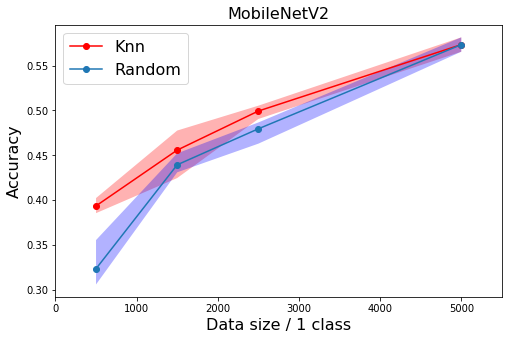

In [0]:
import matplotlib.pyplot as plt
import numpy as np

x = [500, 1500, 2500, 5000]

random_boundary_upper = [np.max(random_mobile_500), np.max(random_mobile_1500), np.max(random_mobile_2500), np.max(mobile_5000)]
random_boundary_lower = [np.min(random_mobile_500), np.min(random_mobile_1500), np.min(random_mobile_2500), np.min(mobile_5000)]

knn_boundary_upper = [np.max(knn_mobile_500), np.max(knn_mobile_1500), np.max(knn_mobile_2500), np.max(mobile_5000)]
knn_boundary_lower = [np.min(knn_mobile_500), np.min(knn_mobile_1500), np.min(knn_mobile_2500), np.min(mobile_5000)]

plt.figure(figsize=(8,5))
plt.title("MobileNetV2", fontsize=16)
plt.xlabel("Data size / 1 class", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.xlim(0,5500)
plt.plot(x, [np.mean(knn_mobile_500), np.mean(knn_mobile_1500), np.mean(knn_mobile_2500), np.mean(mobile_5000)], "-o", label="Knn", c="r")
plt.fill_between(x, knn_boundary_upper, knn_boundary_lower, facecolor='r',alpha=0.3)
plt.plot(x, [np.mean(random_mobile_500), np.mean(random_mobile_1500), np.mean(random_mobile_2500), np.mean(mobile_5000)], "-o", label="Random")
plt.fill_between(x, random_boundary_upper, random_boundary_lower, facecolor='b',alpha=0.3)
plt.legend(fontsize=16)
plt.show()

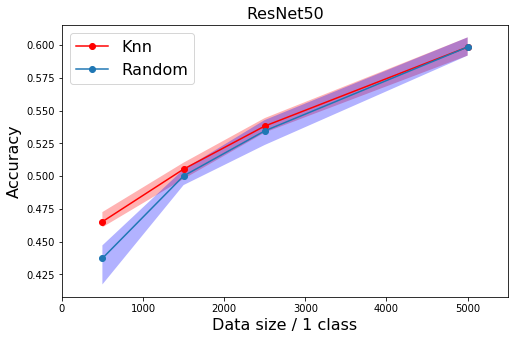

In [0]:
import matplotlib.pyplot as plt
import numpy as np

x = [500, 1500, 2500, 5000]

random_boundary_upper = [np.max(random_resnet_500), np.max(random_resnet_1500), np.max(random_resnet_2500), np.max(resnet_5000)]
random_boundary_lower = [np.min(random_resnet_500), np.min(random_resnet_1500), np.min(random_resnet_2500), np.min(resnet_5000)]

knn_boundary_upper = [np.max(knn_resnet_500), np.max(knn_resnet_1500), np.max(knn_resnet_2500), np.max(resnet_5000)]
knn_boundary_lower = [np.min(knn_resnet_500), np.min(knn_resnet_1500), np.min(knn_resnet_2500), np.min(resnet_5000)]

plt.figure(figsize=(8,5))
plt.title("ResNet50", fontsize=16)
plt.xlabel("Data size / 1 class", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.xlim(0,5500)
plt.plot(x, [np.mean(knn_resnet_500), np.mean(knn_resnet_1500), np.mean(knn_resnet_2500), np.mean(resnet_5000)], "-o", label="Knn", c="r")
plt.fill_between(x, knn_boundary_upper, knn_boundary_lower, facecolor='r',alpha=0.3)
plt.plot(x, [np.mean(random_resnet_500), np.mean(random_resnet_1500), np.mean(random_resnet_2500), np.mean(resnet_5000)], "-o", label="Random")
plt.fill_between(x, random_boundary_upper, random_boundary_lower, facecolor='b',alpha=0.3)
plt.legend(fontsize=16)
plt.show()